In [ ]:
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 1. Simple CNN Model (with extra pooling)

class SimpleCNN(nn.Module):
    """
    A basic CNN with two convolutional layers and two fully connected layers.
    An extra pooling layer is added to reduce the feature map from 16x16 to 8x8.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # After conv2 and one pool, feature map is 16x16; adding another pool yields 8x8.
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))            # (B, 32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # (B, 64, 16, 16)
        x = self.pool(x)                       # (B, 64, 8, 8)
        x = x.view(x.size(0), -1)              # Flatten to (B, 64*8*8 = 4096)
        x = F.relu(self.fc1(x))                # (B, 128)
        x = self.fc2(x)                        # (B, num_classes)
        return x

In [ ]:
# 2. Vision Transformer (ViT) Model (Simplified)

class NewGELUActivation(nn.Module):
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) *
                                               (input + 0.044715 * torch.pow(input, 3.0))))

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size,
                                    kernel_size=self.patch_size, stride=self.patch_size)
    def forward(self, x):
        x = self.projection(x)              # (B, hidden_size, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)    # (B, num_patches, hidden_size)
        return x

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(config)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"])
        )
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    def forward(self, x):
        x = self.patch_embeddings(x)
        B = x.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, hidden_size)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, num_patches+1, hidden_size)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

class AttentionHead(nn.Module):
    def __init__(self, hidden_size, head_size, dropout):
        super().__init__()
        self.query = nn.Linear(hidden_size, head_size)
        self.key = nn.Linear(hidden_size, head_size)
        self.value = nn.Linear(hidden_size, head_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(Q.size(-1))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return out, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_heads = config["num_attention_heads"]
        self.head_size = self.hidden_size // self.num_heads
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.hidden_size, self.head_size, config["attention_probs_dropout_prob"])
            for _ in range(self.num_heads)
        ])
        self.linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    def forward(self, x):
        outputs = []
        for head in self.attention_heads:
            out, _ = head(x)
            outputs.append(out)
        out_cat = torch.cat(outputs, dim=-1)  # (B, seq_len, hidden_size)
        out_cat = self.linear(out_cat)
        out_cat = self.dropout(out_cat)
        return out_cat

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.act = NewGELUActivation()
        self.fc2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config["hidden_size"])
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
    def forward(self, x):
        h = x
        x = self.ln1(x)
        x = self.attn(x)
        x = h + x  # Residual connection
        h = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = h + x  # Residual connection
        return x

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([Block(config) for _ in range(config["num_hidden_layers"])])
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

class ViTForClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed = Embeddings(config)
        self.encoder = Encoder(config)
        self.cls_head = nn.Linear(config["hidden_size"], config["num_classes"])
        self._init_weights()
    def forward(self, x):
        x = self.embed(x)           # (B, seq_len, hidden_size)
        x = self.encoder(x)         # (B, seq_len, hidden_size)
        cls_token_out = x[:, 0, :]  # Use the [CLS] token
        logits = self.cls_head(cls_token_out)
        return logits
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=self.config["initializer_range"])
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

In [ ]:
# 3. Data Loading

def get_cifar10_loaders(batch_size=64, num_workers=2):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return trainloader, testloader

In [ ]:
# 4. Training and Evaluation Helpers

def train_one_epoch(model, trainloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# 5. Main Comparison Script

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)

    # Hyperparameters
    num_epochs = 3
    batch_size = 64
    learning_rate = 1e-3

    # Load data
    trainloader, testloader = get_cifar10_loaders(batch_size=batch_size)

    # 1) Simple CNN
    cnn_model = SimpleCNN(num_classes=10).to(device)
    cnn_params = count_parameters(cnn_model)
    print(f"[CNN] Number of trainable parameters: {cnn_params}")

    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    cnn_train_losses, cnn_test_losses = [], []
    cnn_train_accs, cnn_test_accs = [], []
    cnn_epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train_one_epoch(cnn_model, trainloader, cnn_optimizer, criterion, device)
        end_time = time.time()

        test_loss, test_acc = evaluate(cnn_model, testloader, criterion, device)

        cnn_train_losses.append(train_loss)
        cnn_test_losses.append(test_loss)
        cnn_train_accs.append(train_acc)
        cnn_test_accs.append(test_acc)
        cnn_epoch_times.append(end_time - start_time)

        print(f"[CNN][Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% || "
              f"Time: {cnn_epoch_times[-1]:.2f}s")

    # 2) Vision Transformer
    vit_config = {
        "patch_size": 4,
        "hidden_size": 64,
        "num_hidden_layers": 4,
        "num_attention_heads": 4,
        "intermediate_size": 64 * 4,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,
        "num_channels": 3,
        "qkv_bias": True
    }

    vit_model = ViTForClassification(vit_config).to(device)
    vit_params = count_parameters(vit_model)
    print(f"[ViT] Number of trainable parameters: {vit_params}")

    vit_optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate)
    vit_train_losses, vit_test_losses = [], []
    vit_train_accs, vit_test_accs = [], []
    vit_epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train_one_epoch(vit_model, trainloader, vit_optimizer, criterion, device)
        end_time = time.time()

        test_loss, test_acc = evaluate(vit_model, testloader, criterion, device)

        vit_train_losses.append(train_loss)
        vit_test_losses.append(test_loss)
        vit_train_accs.append(train_acc)
        vit_test_accs.append(test_acc)
        vit_epoch_times.append(end_time - start_time)

        print(f"[ViT][Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% || "
              f"Time: {vit_epoch_times[-1]:.2f}s")

    # 6. Plotting Results
    epochs_range = range(1, num_epochs + 1)

    # 6.1. Training and Test Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, cnn_train_accs, label='CNN Train Acc')
    plt.plot(epochs_range, cnn_test_accs, label='CNN Test Acc')
    plt.plot(epochs_range, vit_train_accs, label='ViT Train Acc')
    plt.plot(epochs_range, vit_test_accs, label='ViT Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison')
    plt.legend()

    # 6.2. Training and Test Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, cnn_train_losses, label='CNN Train Loss')
    plt.plot(epochs_range, cnn_test_losses, label='CNN Test Loss')
    plt.plot(epochs_range, vit_train_losses, label='ViT Train Loss')
    plt.plot(epochs_range, vit_test_losses, label='ViT Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig("comparison_accuracy_loss.png")
    plt.show()

    # 6.3. Parameter Count (Bar Chart)
    plt.figure(figsize=(6, 4))
    models = ['CNN', 'ViT']
    param_counts = [cnn_params, vit_params]
    plt.bar(models, param_counts, color=['blue', 'green'])
    plt.ylabel('Number of Parameters')
    plt.title('Parameter Count Comparison')
    plt.savefig("param_count.png")
    plt.show()

    # 6.4. Average Training Time per Epoch (Bar Chart)
    cnn_avg_time = np.mean(cnn_epoch_times)
    vit_avg_time = np.mean(vit_epoch_times)
    plt.figure(figsize=(6, 4))
    plt.bar(models, [cnn_avg_time, vit_avg_time], color=['blue', 'green'])
    plt.ylabel('Time (seconds)')
    plt.title('Avg. Training Time per Epoch')
    plt.savefig("training_time.png")
    plt.show()

    print("\nComparison Summary:")
    print(f" - CNN: {cnn_params} params, final test acc: {cnn_test_accs[-1]:.2f}%, avg epoch time: {cnn_avg_time:.2f}s")
    print(f" - ViT: {vit_params} params, final test acc: {vit_test_accs[-1]:.2f}%, avg epoch time: {vit_avg_time:.2f}s")


Using device: cpu
[CNN] Number of trainable parameters: 545098
[CNN][Epoch 1/3] Train Loss: 1.4494 | Train Acc: 47.61% || Test Loss: 1.0878 | Test Acc: 61.43% || Time: 181.03s
[CNN][Epoch 2/3] Train Loss: 1.1234 | Train Acc: 60.07% || Test Loss: 0.9689 | Test Acc: 66.45% || Time: 181.61s
[CNN][Epoch 3/3] Train Loss: 1.0155 | Train Acc: 64.05% || Test Loss: 0.9285 | Test Acc: 67.65% || Time: 181.23s
[ViT] Number of trainable parameters: 207946
[ViT][Epoch 1/3] Train Loss: 1.8837 | Train Acc: 29.73% || Test Loss: 1.6697 | Test Acc: 39.92% || Time: 273.37s
[ViT][Epoch 2/3] Train Loss: 1.6295 | Train Acc: 40.42% || Test Loss: 1.5249 | Test Acc: 46.87% || Time: 274.40s
[ViT][Epoch 3/3] Train Loss: 1.5311 | Train Acc: 44.33% || Test Loss: 1.4597 | Test Acc: 48.51% || Time: 271.78s


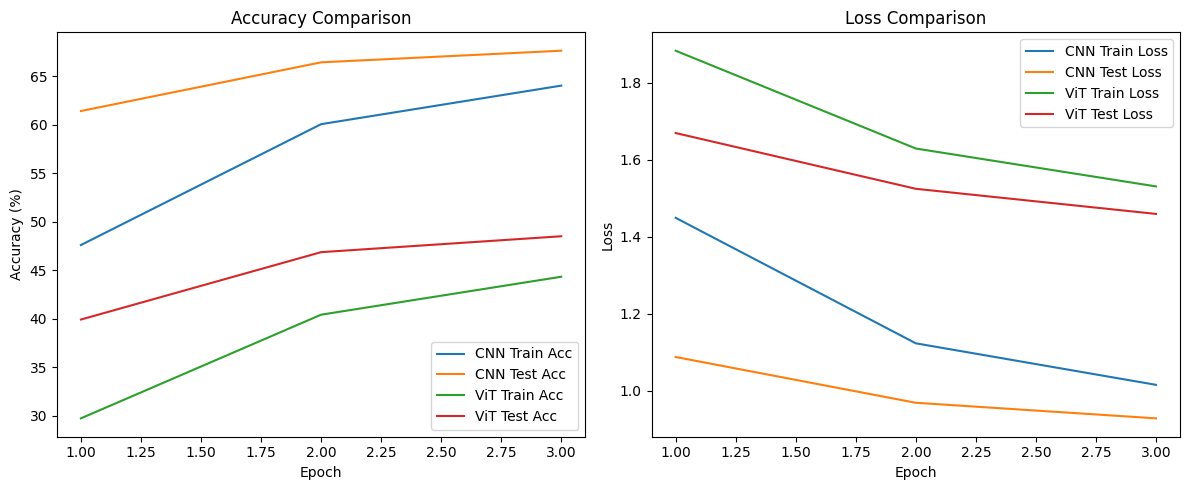

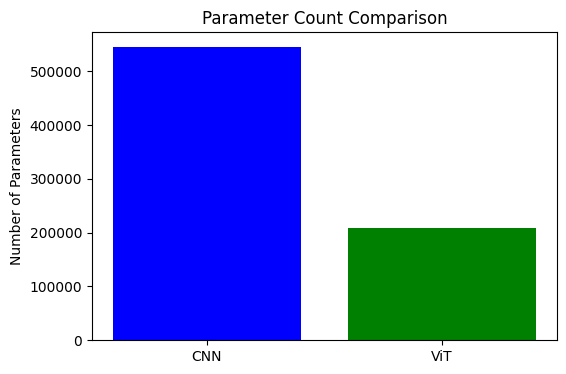

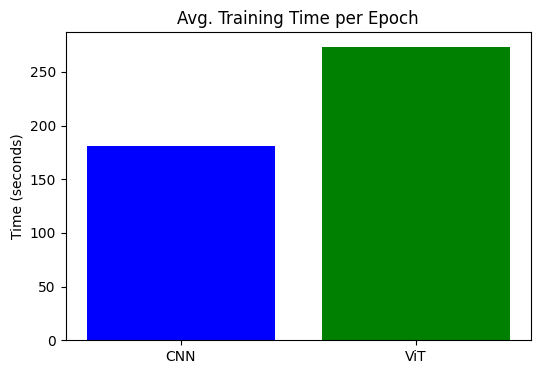


Comparison Summary:
 - CNN: 545098 params, final test acc: 67.65%, avg epoch time: 181.29s
 - ViT: 207946 params, final test acc: 48.51%, avg epoch time: 273.18s


In [18]:
# 7. Entry Point


if __name__ == "__main__":
    main()
